# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from collections import defaultdict
from IPython.display import display

In [2]:
%matplotlib inline

# Read model predictions

In [3]:
path = "./running/external/transformer_hier++_001/"

In [4]:
df = pd.read_csv(os.path.join(path, "error_greedy_test.tsv"), delimiter="\t")
df_stats = pd.read_csv(os.path.join(path, "stats_greedy_test.tsv"), delimiter="\t")

In [5]:
df.shape, df_stats.shape

((7372, 7), (1000, 3))

In [6]:
df.head()

,file,context,gold,generated,loss,bleu,f1_entity
0,MUL1493,"SOS hello , i am trying to find a train that l...",SOS the closest arrival time i can give you is...,SOS i have [value_count] trains that will arri...,9.618665,23.110016,0.000000
1,PMUL2380,"SOS hi , could you help me with some informati...",SOS absolutely ! what attraction were you thin...,SOS what is the name of the attraction you are...,7.836526,0.013512,0.000000
2,PMUL0205,SOS i need a place to stay in the [hotel_area]...,SOS of course ! we have multiple place -s to c...,SOS there are [value_count] hotel -s that meet...,10.653697,0.010309,99.850125
3,PMUL1788,SOS please help me find a hotel called flinche...,SOS it s phone number is [hotel_phone] and is ...,SOS the phone number is [hotel_phone] and the ...,8.462424,31.614887,99.900050
4,PMUL1435,SOS i need to take a train from [train_departu...,SOS i have [value_count] that leave after [tra...,SOS there are [value_count] trains that leave ...,8.050355,23.080884,99.850125


In [7]:
df.describe()

,loss,bleu,f1_entity
count,7372.000000,7372.000000,7372.000000
mean,7.985338,20.556856,52.385608
std,2.600812,22.931500,46.824719
min,0.030367,0.000009,0.000000
25%,7.028389,0.017286,0.000000
50%,8.576160,16.342323,66.577830
75%,9.702811,33.934150,99.850125
max,14.540479,96.821333,99.935741


# Correlation b/w Metrics

## [DEFINE] Context Length + Bleu bins

In [8]:
df['context_length'] = df.apply(lambda r: len(r['context'].split('<br>')), 1)

In [9]:
df['bleu_bin'] = df.apply(lambda r: r['bleu']//10, 1)

In [10]:
df.sample(10)

,file,context,gold,generated,loss,bleu,f1_entity,context_length,bleu_bin
6547,MUL2457,SOS i am looking for corsica restaurant -s in ...,SOS certainly . would time would you like to l...,SOS i can help you with that . what time would...,10.534257,27.249756,0.000000,15,2.0
5153,MUL1642,"SOS hello , i am trying to find a train that g...","SOS unfortunately , the restaurant does not ha...","SOS i am sorry , but they are all booked up . ...",7.989841,0.011213,0.000000,11,0.0
1537,MUL1596,SOS hello ! i would like to eat at an [restaur...,SOS sure ! how many people and what time ? EOS,SOS how many people and what time would you li...,10.043787,37.502299,0.000000,3,3.0
1859,MUL1899,"SOS i need some time in the sun , can you help...",SOS their address is [attraction_address] . th...,SOS the phone number is [attraction_phone] and...,9.767660,21.451295,99.900050,3,2.0
5012,PMUL3897,SOS i am looking for things to do in the [attr...,"SOS [hotel_name] has parking , its a [value_co...","SOS yes , [hotel_name] has free parking and is...",7.792147,0.546633,79.920040,11,0.0
3670,PMUL2746,SOS i am looking for a place -s to stay in [ho...,"SOS do you mean at the aylesbray ? yes , they ...","SOS [hotel_name] is a nice place , it has free...",9.951080,0.014953,0.000000,7,0.0
3267,SNG02319,SOS i would like to book a taxi to the [attrac...,SOS i need a taxi to the [attraction_name] . EOS,SOS i am glad i could be of service . EOS,9.439457,0.015690,0.000000,7,0.0
1250,PMUL4547,SOS please find a restaurant called [restauran...,SOS yes your booking was successful and the re...,SOS booking was successful . the table will be...,11.943419,29.945171,66.577830,3,2.0
3847,PMUL4255,SOS can you help me find a train going to [tra...,SOS it will be [train_price] pounds per ticket...,SOS the price per ticket is [train_price] poun...,5.035406,37.629582,99.850125,7,3.0
5835,SNG0892,SOS i am looking for a hotel with at least a [...,"SOS sure , it is at [hotel_address] . do you n...",SOS the address is [hotel_address] . is there ...,10.226249,0.014625,99.850125,13,0.0


In [11]:
df.iloc[2099]['generated']

'SOS sure , what is your departure site and what time would you like to leave ? EOS'

In [12]:
df.iloc[2099]['gold']

'SOS where you will be traveling from and when would you like to leave ? EOS'

## Bleu vs. Context Length/turns

Observing slight decrease in bleu with context length.
 - Would be interesting to compare high context length performance across models
 - Check how many samples are availble for training for different context length

<AxesSubplot:title={'center':'bleu'}, xlabel='context_length'>

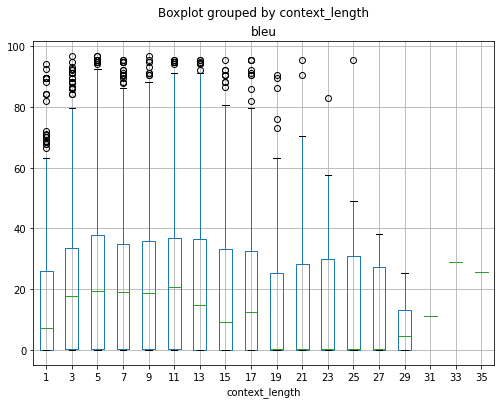

In [13]:
df.boxplot(column='bleu', by='context_length', figsize=(8,6))

<AxesSubplot:title={'center':'bleu_bin'}, xlabel='context_length'>

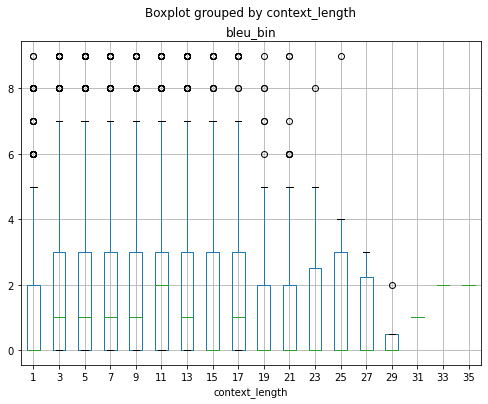

In [14]:
df.boxplot(column='bleu_bin', by='context_length', figsize=(8,6))

## [DEFINE] num_entities

In [15]:
regex_entity = r'\[([a-z\_\-]+)\]'

In [16]:
df['gold_entities'] = df.apply(lambda r: re.findall(regex_entity, r['gold']), 1)
df['num_entities'] = df.apply(lambda r: len(r['gold_entities']), 1)

<AxesSubplot:title={'center':'f1_entity'}, xlabel='num_entities'>

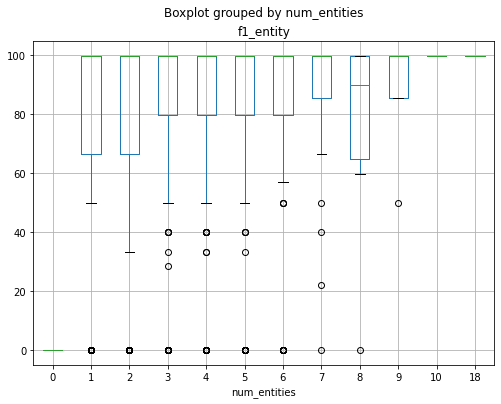

In [17]:
df.boxplot(column='f1_entity', by='num_entities', figsize=(8,6))

## [EXP] Scatter all pairs

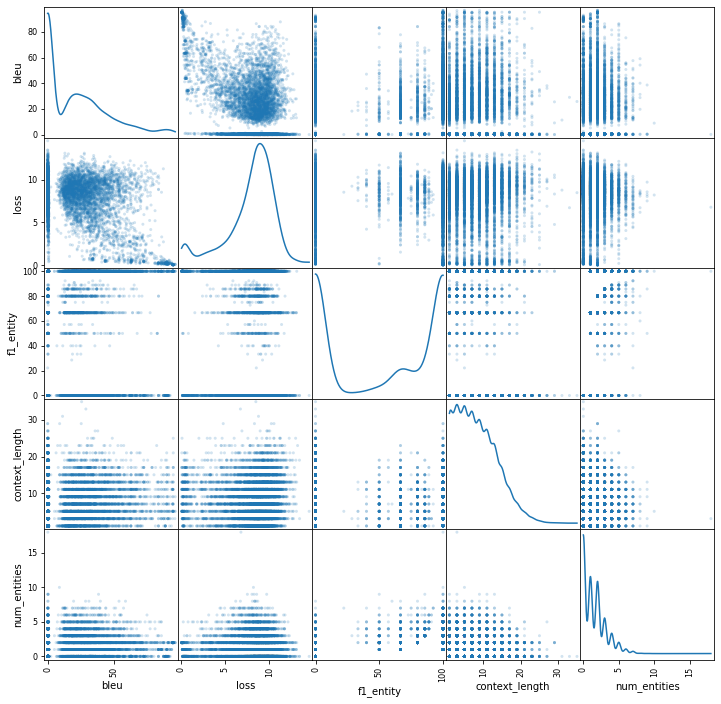

In [18]:
_ = scatter_matrix(df[['bleu', 'loss', 'f1_entity', 'context_length', 'num_entities']], alpha=0.2, diagonal='kde', figsize=(12,12))

## [EXP] Entitywise Avg. f1-entity

In [19]:
entity_log = {
    'entity':[],
    'loss':[],
    'bleu':[],
    'f1_entity':[],
    'context_length':[]
}
for _, row in df.iterrows():
    for e in row['gold_entities']:
        entity_log['entity'].append(e)
        entity_log['loss'].append(row['loss'])
        entity_log['bleu'].append(row['bleu'])
        entity_log['f1_entity'].append(row['f1_entity'])
        entity_log['context_length'].append(row['context_length'])

In [20]:
df_entity_log = pd.DataFrame.from_dict(entity_log)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 [Text(1, 0, 'attraction_address'),
  Text(2, 0, 'attraction_area'),
  Text(3, 0, 'attraction_name'),
  Text(4, 0, 'attraction_phone'),
  Text(5, 0, 'attraction_postcode'),
  Text(6, 0, 'attraction_pricerange'),
  Text(7, 0, 'hotel_address'),
  Text(8, 0, 'hotel_area'),
  Text(9, 0, 'hotel_name'),
  Text(10, 0, 'hotel_phone'),
  Text(11, 0, 'hotel_postcode'),
  Text(12, 0, 'hotel_pricerange'),
  Text(13, 0, 'hotel_reference'),
  Text(14, 0, 'police_address'),
  Text(15, 0, 'police_name'),
  Text(16, 0, 'police_phone'),
  Text(17, 0, 'restaurant_address'),
  Text(18, 0, 'restaurant_area'),
  Text(19, 0, 'restaurant_food'),
  Text(20, 0, 'restaurant_name'),
  Text(21, 0, 'restaurant_phone'),
  Text(22, 0, 'restaurant_postcode'),
  Text(23, 0, 'restaurant_pricerange'),
  Text(24, 0, 'restaurant_reference'),
  Text

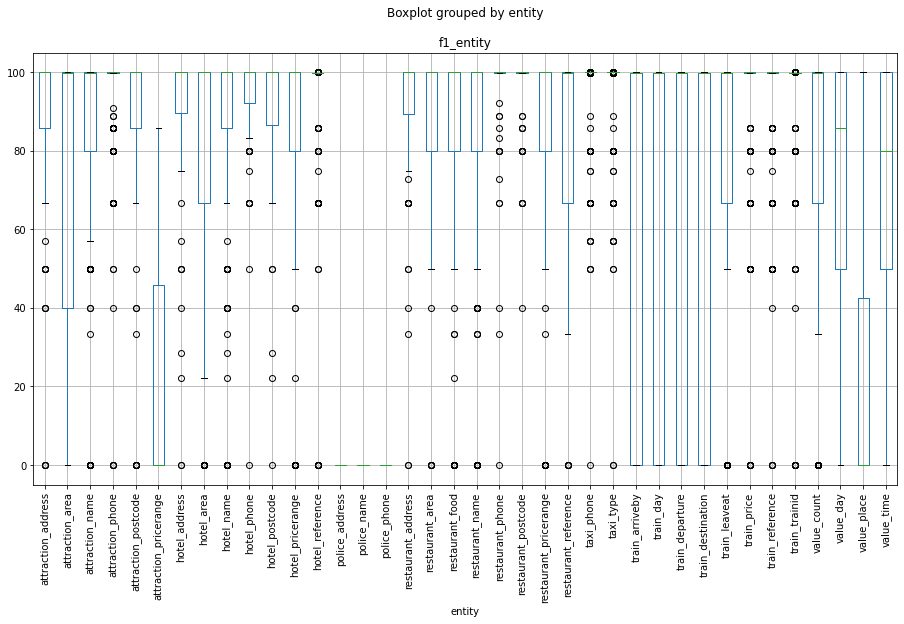

In [21]:
df_entity_log.boxplot(column='f1_entity', by='entity', figsize=(15,8))
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 [Text(1, 0, 'attraction_address'),
  Text(2, 0, 'attraction_area'),
  Text(3, 0, 'attraction_name'),
  Text(4, 0, 'attraction_phone'),
  Text(5, 0, 'attraction_postcode'),
  Text(6, 0, 'attraction_pricerange'),
  Text(7, 0, 'hotel_address'),
  Text(8, 0, 'hotel_area'),
  Text(9, 0, 'hotel_name'),
  Text(10, 0, 'hotel_phone'),
  Text(11, 0, 'hotel_postcode'),
  Text(12, 0, 'hotel_pricerange'),
  Text(13, 0, 'hotel_reference'),
  Text(14, 0, 'police_address'),
  Text(15, 0, 'police_name'),
  Text(16, 0, 'police_phone'),
  Text(17, 0, 'restaurant_address'),
  Text(18, 0, 'restaurant_area'),
  Text(19, 0, 'restaurant_food'),
  Text(20, 0, 'restaurant_name'),
  Text(21, 0, 'restaurant_phone'),
  Text(22, 0, 'restaurant_postcode'),
  Text(23, 0, 'restaurant_pricerange'),
  Text(24, 0, 'restaurant_reference'),
  Text

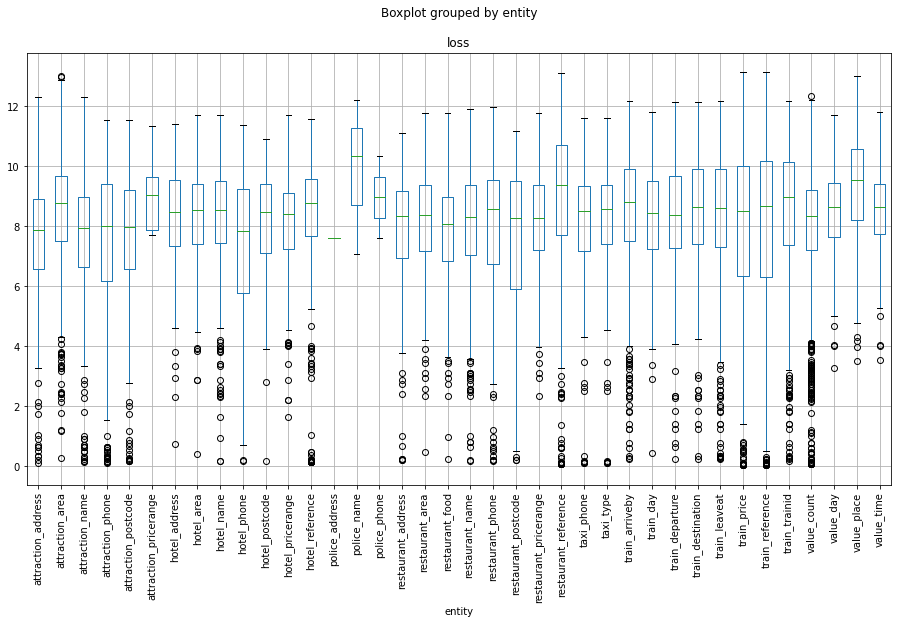

In [22]:
df_entity_log.boxplot(column='loss', by='entity', figsize=(15,8))
plt.xticks(rotation=90)

## [DEFINE] pred_entities

In [23]:
df['pred_entities'] = df.apply(lambda r: re.findall(regex_entity, r['generated']), 1)
df['num_pred_entities'] = df.apply(lambda r: len(r['pred_entities']), 1)

In [24]:
df.sample(4)

,file,context,gold,generated,loss,bleu,f1_entity,context_length,bleu_bin,gold_entities,num_entities,pred_entities,num_pred_entities
4729,MUL2051,SOS i am looking for a train from [train_depar...,"SOS there are many options available , any oth...",SOS i have [value_count] options for you . EOS,7.049130,0.000341,0.000000,9,0.0,[],0,[value_count],1
5945,MUL1515,SOS need a restaurant that is [restaurant_pric...,SOS it'll be [train_price] pounds . EOS,SOS the price is [train_price] pounds . EOS,8.011720,31.559856,99.850125,13,3.0,[train_price],1,[train_price],1
3661,SNG0004,SOS i would like to book a taxi to go to [attr...,SOS is there anything else i can help you with...,SOS you are welcome . have a great day . EOS,10.884851,0.000398,0.000000,7,0.0,[],0,[],0
1720,SNG0888,SOS we need to find a guesthouse of [hotel_pri...,SOS the [hotel_name] is a [value_count] star g...,SOS the [hotel_name] is a [value_count] star g...,7.869386,47.331163,99.916703,3,4.0,"[hotel_name, value_count, hotel_area]",3,"[hotel_name, value_count, hotel_area]",3


# Extracting Samples

## [SAMPLES] By Loss

In [25]:
def print_row(r):
    print(f"\n[CONTEXT]")
    
    print("{}".format('\n'.join(r['context'].split('<br>')[-5:])))
    
    print(f"\n[GOLD]: {r['gold']}")
    
    print(f"\n[GEN]: {r['generated']}")

In [26]:
for _, row in df.nlargest(2, ['loss']).iterrows():
    print_row(row)


[CONTEXT]
SOS i am looking for a place to dine in the [restaurant_area] that serves [restaurant_food] food . EOS
SOS [restaurant_name] serves [restaurant_food] is in the [restaurant_area] . the price range is [restaurant_pricerange] . EOS
SOS great . please reserve a table for [value_count] people dining on [value_day] at [value_time] and send me the reference number . EOS
SOS your booking was successful . your reference number is [restaurant_reference] . please be advised that your table will be reserved for [value_count] minutes . EOS
SOS thank you very much ! EOS

[GOLD]: SOS take care and enjoy ! EOS

[GEN]: SOS is there anything else i can help you with ? EOS

[CONTEXT]
SOS i am looking for information about the [attraction_name] in [value_place] . EOS
SOS the [attraction_name] is a museum in the center of town . EOS
SOS ok , great . thank you so much for your help . EOS

[GOLD]: SOS thank you for using our service ! EOS

[GEN]: SOS you are welcome . is there anything else i can 

In [27]:
for _, row in df.nsmallest(2, ['loss']).iterrows():
    print_row(row)


[CONTEXT]
SOS does not matter . book [value_count] of them for myself and [value_count] nights starting from [value_day] . EOS
SOS booking at the [hotel_name] was successful , the reference number is [hotel_reference] . it is located at [hotel_address] , postal code [hotel_postcode] . is there anything else i can help with ? EOS
SOS yes , can you help me find a train ? EOS
SOS i can . all i need is your departure location , destination , day and when you would like to either leave or arrive by . EOS
SOS i will be leaving [train_departure] the same day as my hotel booking . EOS

[GOLD]: SOS booking was successful , the total fee is [train_price] gbp payable at the station . reference number is [train_reference] . EOS

[GEN]: SOS booking was successful , the total fee is [train_price] gbp payable at the station . reference number is [train_reference] . EOS

[CONTEXT]
SOS yes i am also looking for a train that arrives in [train_destination] at [train_arriveby] . EOS
SOS what is your depa

In [28]:
for _, row in df.nsmallest(4, ['f1_entity']).iterrows():
    print_row(row)


[CONTEXT]
SOS hello , i am trying to find a train that leaves from [train_departure] and arrives here by [train_arriveby] today . can you help me book a ticket ? EOS

[GOLD]: SOS the closest arrival time i can give you is [train_arriveby] , is that ok ? and how many tickets would you like ? EOS

[GEN]: SOS i have [value_count] trains that will arrive by [train_arriveby] . how many tickets would you like to purchase ? EOS

[CONTEXT]
SOS hi , could you help me with some information on a particular attraction ? EOS

[GOLD]: SOS absolutely ! what attraction were you thinking of ? EOS

[GEN]: SOS what is the name of the attraction you are looking for ? EOS

[CONTEXT]
SOS i need help finding a train . can you help ? EOS

[GOLD]: SOS yes i can help you find a train what station are you going to and from and at what time would you like to leave ? EOS

[GEN]: SOS where are you departing from and what is your destination ? EOS

[CONTEXT]
SOS are there any [restaurant_food] restaurant -s in the 

In [29]:
for _, row in df.nlargest(50, ['context_length']).sample(2).iterrows():
    print_row(row)


[CONTEXT]
SOS thank you . i also need a train from [train_departure] on [train_day] . EOS
SOS sure . where are you headed to and what time would you like to leave [train_departure] ? EOS
SOS i must arrive by [train_arriveby] . EOS
SOS okay ! where are you going ? EOS
SOS i am going to [train_destination] . EOS

[GOLD]: SOS [train_trainid] arrives at [train_arriveby] . would you like to reserve seats ? EOS

[GEN]: SOS [train_trainid] arrives by [train_arriveby] . would you like me to book it for you ? EOS

[CONTEXT]
SOS no on the hotel . what is the train id for that [value_count] , and how long is the travel time . EOS
SOS the train id for that is [train_trainid] and the travel time is [value_count] minutes . would you like me to book you a seat ? EOS
SOS no , that would all right . i'll do it myself . EOS
SOS ok is there anything else that i can assist you with ? EOS
SOS no , if you are sure there are no [value_count] star [attraction_pricerange] -ly priced hotel -s with free parking

In [30]:
for _, row in df.nlargest(5, ['num_entities']).iterrows():
    print_row(row)


[CONTEXT]
SOS i am looking for an [restaurant_pricerange] restaurant in the [restaurant_area] part of town . EOS
SOS there are [value_count] [restaurant_pricerange] restaurant -s in the [restaurant_area] of town . did you have a type of food in mind ? EOS
SOS can you give me a couple of examples of different cuisines that are available ? EOS

[GOLD]: SOS there is [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , and [restaurant_food] food available in the [restaurant_area] . EOS

[GEN]: SOS yes , there is [restaurant_food] food in the [restaurant_area] of town . EOS

[CONTEXT]
SOS i am planning a trip in [value_place] EOS
SOS i can help book a train to get you here . EOS
SOS ok i will book it for you EOS
SOS how can i h

## Compare Target and Predicted Entities

In [31]:
ent_pred_ledger = defaultdict(list)
for _, row in df.iterrows():
    gold = set(row['gold_entities'])
    gen = set(row['pred_entities'])
    for e in gold - gen:
        # These didn't get predicted, lost count
        ent_pred_ledger[e].append(-1)
        
    for e in gen - gold:
        # These weren't supposed to get predicted, excess count
        ent_pred_ledger[e].append(+1)
        
    for e in gen.intersection(gold):
        # These are ok
        ent_pred_ledger[e].append(0)

In [32]:
df_ent_pred_ledger = {}
for e in ent_pred_ledger:
    preds = np.array(ent_pred_ledger[e])
#     print(f"\n{e.upper()}")
    fp = (preds == 1).sum()
    fn = (preds == -1).sum()
    tp = (preds == 0).sum()
#     print(f" TP: {tp}, {100*tp/(fp+fn+tp):0.2F}")
#     print(f" FP: {fp}, {100*fp/(fp+fn+tp):0.2F}")
#     print(f" FN: {fn}, {100*fn/(fp+fn+tp):0.2F}")
    df_ent_pred_ledger[e] = {
        'gold_appear': fn + tp,
        'tpr': 100*tp/(fp+fn+tp),
        'fpr': 100*fp/(fp+fn+tp),
        'fnr': 100*fn/(fp+fn+tp),
        'tp': tp,
        'fp': fp,
        'fn': fn,
    }
df_ent_pred_ledger = pd.DataFrame.from_dict(df_ent_pred_ledger, orient='index')
df_ent_pred_ledger = df_ent_pred_ledger.sort_values('gold_appear', ascending=False)

In [33]:
df_ent_pred_ledger.sort_values('tpr', ascending=False)

,gold_appear,tpr,fpr,fnr,tp,fp,fn
hotel_phone,92,96.739130,0.000000,3.260870,89,0,3
taxi_phone,201,96.135266,2.898551,0.966184,199,6,2
taxi_type,199,95.631068,3.398058,0.970874,197,7,2
hotel_reference,235,95.020747,2.489627,2.489627,229,6,6
restaurant_phone,99,95.000000,1.000000,4.000000,95,1,4
train_reference,292,93.464052,4.575163,1.960784,286,14,6
attraction_postcode,204,92.233010,0.970874,6.796117,190,2,14
restaurant_reference,280,91.610738,6.040268,2.348993,273,18,7
train_trainid,444,91.048035,3.056769,5.895197,417,14,27
attraction_phone,219,90.909091,5.194805,3.896104,210,12,9


## Macro-Avg Entity Prediction Success at different context lengths

In [34]:
def proc_row(row):
    gold = set(row['gold_entities'])
    gen = set(row['pred_entities'])
    
    L = len(gold)
    entity_recall = len(gen.intersection(gold))/L if L > 0 else 0
    entity_prec = len(gen.intersection(gold))/len(gen) if len(gen) > 0 else 0
    entity_f1 = 2*entity_prec*entity_recall/(entity_recall+entity_prec) if (entity_recall+entity_prec) >0 else 0
        
    return entity_prec, entity_recall, entity_f1

In [35]:
df['entity_prec'] = df.apply(lambda r: proc_row(r)[0], 1)
df['entity_recall'] = df.apply(lambda r: proc_row(r)[1], 1)
df['entity_f1'] = df.apply(lambda r: proc_row(r)[2], 1)

In [36]:
df[(df['num_entities'] > 0)].describe()

,loss,bleu,f1_entity,context_length,bleu_bin,num_entities,num_pred_entities,entity_prec,entity_recall,entity_f1
count,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000
mean,7.956311,23.601431,80.138349,7.520025,2.022204,2.303382,2.240506,0.831785,0.847267,0.824725
std,2.440410,22.639545,33.613121,4.901792,2.124821,1.409984,1.635295,0.316075,0.312816,0.302857
min,0.030367,0.000009,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.993161,0.465744,66.577830,3.000000,0.000000,1.000000,1.000000,0.750000,1.000000,0.666667
50%,8.483127,20.879598,99.850125,7.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
75%,9.561034,36.227568,99.900050,11.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000
max,13.131967,96.821333,99.935741,29.000000,9.000000,18.000000,23.000000,1.000000,1.000000,1.000000


## [EXP] Entity prec/recall/f1 vs. Context Length

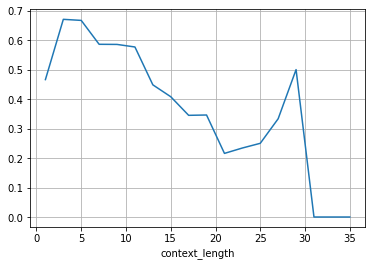

In [37]:
df.groupby('context_length')['entity_prec'].mean().plot()
plt.grid()

<AxesSubplot:xlabel='context_length'>

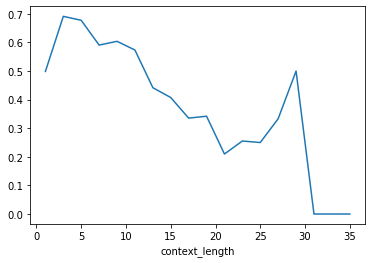

In [38]:
df.groupby('context_length')['entity_recall'].mean().plot()

<AxesSubplot:xlabel='context_length'>

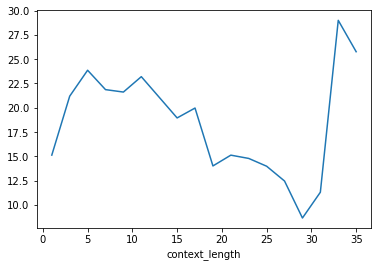

In [39]:
df.groupby('context_length')['bleu'].mean().plot()

Text(0.5, 1.0, 'Entity-F1 Score')

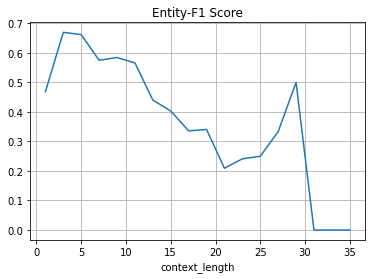

In [40]:
df.groupby('context_length')['entity_f1'].mean().plot()
plt.grid()
plt.title("Entity-F1 Score")

Text(0.5, 1.0, 'Number of samples in test set')

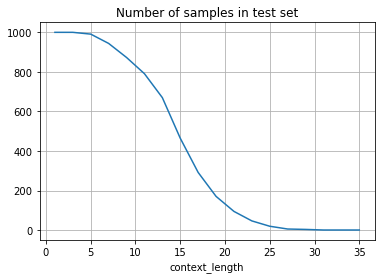

In [41]:
df.groupby('context_length')['file'].count().plot()
plt.grid()
plt.title("Number of samples in test set")

## [RESULT] Correctness of entities predicted

Our model is more accurate in the entities being mentioned also uses appropriate number of entities in the generated response. Our model uses almost the same or sometimes less numbers of entities in its responses compared to Marco as is more accurate on avg.

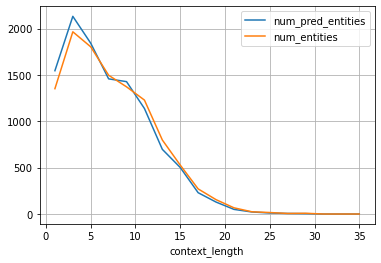

In [68]:
df.groupby('context_length')[['num_pred_entities', 'num_entities']].sum().plot()
plt.grid()

Text(0.5, 1.0, 'Histogram of Entity Precision')

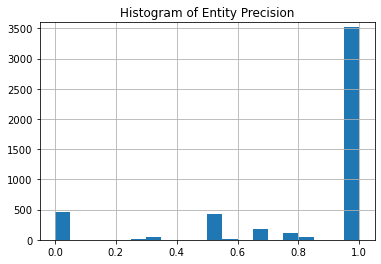

In [75]:
df.loc[df['num_entities']>0, ['entity_prec']].hist(bins=20)
plt.ylim(0, 3600)
plt.title("Histogram of Entity Precision")

Text(0.5, 1.0, 'Histogram of Entity Recall')

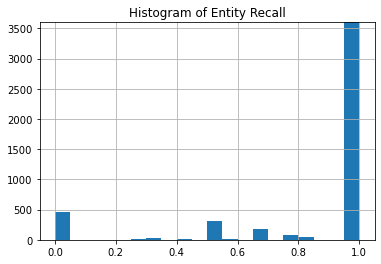

In [76]:
df.loc[df['num_entities']>0, ['entity_recall']].hist(bins=20)
plt.ylim(0, 3600)
plt.title("Histogram of Entity Recall")

## [EXP] People vs. Number of Entities

<AxesSubplot:xlabel='num_entities'>

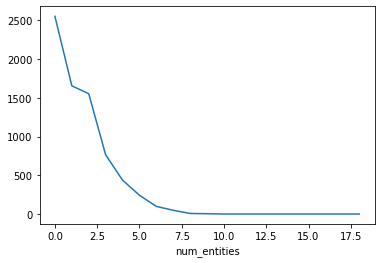

In [43]:
df.groupby('num_entities')['file'].count().plot()

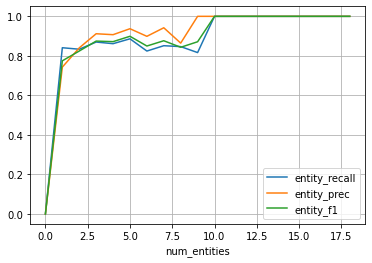

In [57]:
df.groupby('num_entities')[['entity_recall', 'entity_prec', 'entity_f1']].mean().plot()
plt.grid()

<AxesSubplot:xlabel='num_entities'>

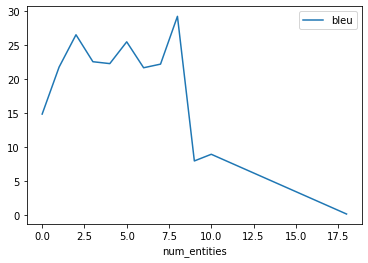

In [45]:
df.groupby('num_entities')[['bleu']].mean().plot()

(0.0, 15.0)

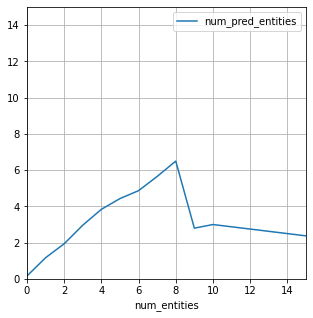

In [46]:
df.groupby('num_entities')[['num_pred_entities']].mean().plot(figsize=(5,5))
plt.grid()
plt.xlim((0, 15))
plt.ylim((0, 15))

## [DEFINE] Avg. Response Length

Mean response length: 17.900705371676615


(0.0, 50.0)

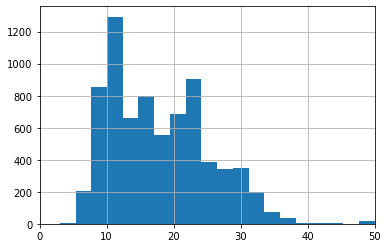

In [71]:
response_lengths = df.apply(lambda x: len(x["generated"].split()), 1)
print("Mean response length:", response_lengths.mean())
response_lengths.hist(bins=20)
plt.xlim(0, 50)

# Process Dialog level Stats (Inform/Success)

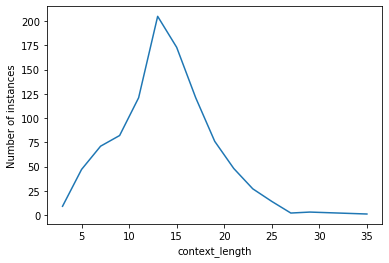

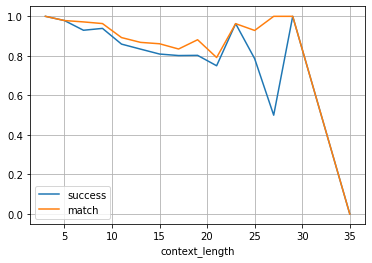

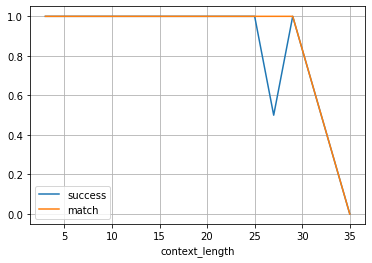

In [48]:
df_temp = df.groupby('file')[['context_length']].max().reset_index()
df_temp['file'] = df_temp.apply(lambda r: r['file']+'.json', 1)
df_combo = pd.merge(df_temp, df_stats, how='inner', on='file')

df_combo.groupby('context_length')['context_length'].count().plot()
plt.ylabel('Number of instances')

df_combo.groupby('context_length')[['success', 'match']].mean().plot()
plt.grid()

df_combo.groupby('context_length')[['success', 'match']].median().plot()
plt.grid()

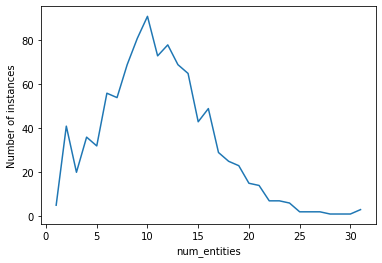

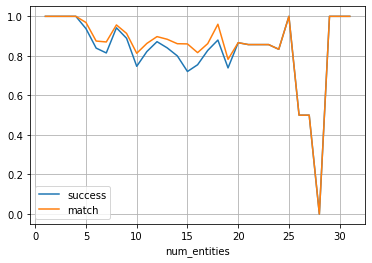

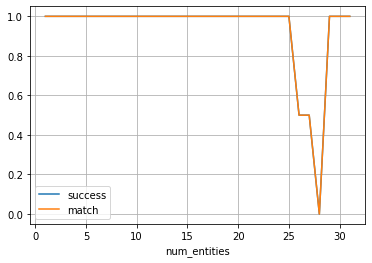

In [49]:
df_temp = df.groupby('file')[['num_entities']].sum().reset_index()
df_temp['file'] = df_temp.apply(lambda r: r['file']+'.json', 1)
df_combo = pd.merge(df_temp, df_stats, how='inner', on='file')

df_combo.groupby('num_entities')['num_entities'].count().plot()
plt.ylabel('Number of instances')

df_combo.groupby('num_entities')[['success', 'match']].mean().plot()
plt.grid()

df_combo.groupby('num_entities')[['success', 'match']].median().plot()
plt.grid()

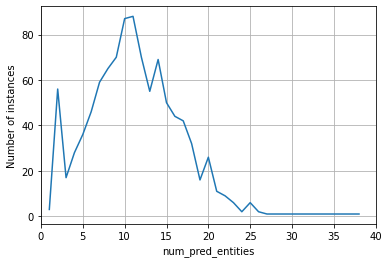

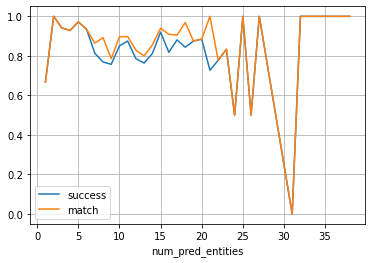

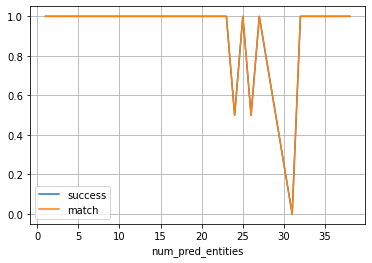

In [56]:
df_temp = df.groupby('file')[['num_pred_entities']].sum().reset_index()
df_temp['file'] = df_temp.apply(lambda r: r['file']+'.json', 1)
df_combo = pd.merge(df_temp, df_stats, how='inner', on='file')

df_combo.groupby('num_pred_entities')['num_pred_entities'].count().plot()
plt.grid(); plt.xlim(0, 40);
plt.ylabel('Number of instances')

df_combo.groupby('num_pred_entities')[['success', 'match']].mean().plot()
plt.grid()

df_combo.groupby('num_pred_entities')[['success', 'match']].median().plot()
plt.grid()

## Match/Success pairwise stats

In [51]:
for key, g in df_stats.groupby(['match', 'success']):
    print(key, g.shape[0], 'rows')

(0.0, 0) 112 rows
(1.0, 0) 40 rows
(1.0, 1) 848 rows


## Find dialogs by match/success constraints:

In [52]:
df2 = df.copy()
df2['file'] = df2.apply(lambda r: r['file']+'.json', 1)

In [53]:
df_full = df_stats.merge(df2, on=['file'])

In [54]:
for _, r in df_stats.iterrows():
    file = r['file']
    match = r['match']
    success = r['success']
    if match == 1 and success == 0:
        piece = df2[df2['file'] == file]
        showme = ['gold_entities', 'num_entities', 'pred_entities', 'num_pred_entities', 'entity_prec', 'entity_recall']
        
        print(f"{file}, Match: {match}, Success: {success}")
        for _, rc in piece.iterrows():
            print('-------------------------------')
            display(piece.loc[_, showme])
            print('-------------------------------')
            # print('[CON]', rc['context'])
            print('[GOLD]', rc['gold'])
            print('[GEN]', rc['generated'])
        break

PMUL0079.json, Match: 1.0, Success: 0
-------------------------------


gold_entities        [hotel_pricerange, value_count, hotel_priceran...
num_entities                                                         4
pred_entities        [value_count, hotel_pricerange, value_count, h...
num_pred_entities                                                    4
entity_prec                                                          1
entity_recall                                                        1
Name: 954, dtype: object

-------------------------------
[GOLD] SOS i have several options , almost all of which are [hotel_pricerange] guesthouses . i do have [value_count] [hotel_pricerange] [value_count] , too . would you like to book a room ? EOS
[GEN] SOS i have [value_count] hotel -s that are [hotel_pricerange] -ly priced and [value_count] [hotel_pricerange] . would you like me to book you a room ? EOS
-------------------------------


gold_entities        []
num_entities          0
pred_entities        []
num_pred_entities     0
entity_prec           0
entity_recall         0
Name: 1954, dtype: object

-------------------------------
[GOLD] SOS ok , how many are in your party , what day will you arrive , and how many nights will you be staying ? EOS
[GEN] SOS i can help you with that . what day will you be arriving and how many people are you staying ? EOS
-------------------------------


gold_entities                               [restaurant_phone]
num_entities                                                 1
pred_entities        [restaurant_phone, restaurant_pricerange]
num_pred_entities                                            2
entity_prec                                                0.5
entity_recall                                                1
Name: 2945, dtype: object

-------------------------------
[GOLD] SOS as i mentioned it is cherap and the phone number is [restaurant_phone] . EOS
[GEN] SOS the phone number is [restaurant_phone] and the price is [restaurant_pricerange] . EOS
-------------------------------


gold_entities        []
num_entities          0
pred_entities        []
num_pred_entities     0
entity_prec           0
entity_recall         0
Name: 3892, dtype: object

-------------------------------
[GOLD] SOS sure thing what kind of food do you want ? EOS
[GEN] SOS what type of food would you like ? EOS
-------------------------------


gold_entities                       [hotel_name, hotel_pricerange]
num_entities                                                     2
pred_entities        [hotel_name, hotel_pricerange, hotel_address]
num_pred_entities                                                3
entity_prec                                               0.666667
entity_recall                                                    1
Name: 4766, dtype: object

-------------------------------
[GOLD] SOS the [hotel_name] is in the [hotel_pricerange] price range and they do offer parking . can i help with anything else ? EOS
[GEN] SOS the [hotel_name] is in the [hotel_pricerange] price range . their address is [hotel_address] . is there anything else i can help you with ? EOS
-------------------------------


gold_entities        [restaurant_name, restaurant_food]
num_entities                                          2
pred_entities        [restaurant_name, restaurant_food]
num_pred_entities                                     2
entity_prec                                           1
entity_recall                                         1
Name: 5563, dtype: object

-------------------------------
[GOLD] SOS there is [restaurant_name] that serves [restaurant_food] food . would you like to book a table there ? EOS
[GEN] SOS i would recommend [restaurant_name] . it serves [restaurant_food] food . would you like me to book it for you ? EOS
-------------------------------


gold_entities                     [restaurant_reference]
num_entities                                           1
pred_entities        [value_count, restaurant_reference]
num_pred_entities                                      2
entity_prec                                          0.5
entity_recall                                          1
Name: 6238, dtype: object

-------------------------------
[GOLD] SOS i have booked it for you ! the reference is [restaurant_reference] . EOS
[GEN] SOS booking was successful . the table will be reserved for [value_count] minutes . reference number is [restaurant_reference] . EOS
-------------------------------


gold_entities        []
num_entities          0
pred_entities        []
num_pred_entities     0
entity_prec           0
entity_recall         0
Name: 6713, dtype: object

-------------------------------
[GOLD] SOS thank you for letting me help you today . EOS
[GEN] SOS you are welcome . have a great day . EOS
